# ロボットアーム - Panda Gym

In [ ]:
import os
import numpy as np
import gymnasium as gym
import panda_gym
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

from gail_algo import GAILTrainer, build_expert_loader
from collect_expert_trajectories import collect_expert_trajectories

# 日本語フォント設定
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Noto Sans CJK JP', 'IPAexGothic', 'Takao']
matplotlib.rcParams['axes.unicode_minus'] = False

* ロボット: Franka Emika Panda マニピュレータの操作タスクをシミュレート。
<br>

* 観測空間:
    - すべてのタスクにグリッパの位置と速度（6値）。
    - 物体を扱うタスクでは位置・姿勢・線形/回転速度が追加（物体1つにつき12値）。
    - グリッパ開閉距離（拘束されていなければ1値）。

* 行動空間:
    - グリッパの平行移動コマンド（x, y, z の3値）。
    - グリッパ開閉コマンド（1値）。
    
* シミュレーション:
    - エージェントの1ステップあたり20タイムステップ（各2ms）。
    - インタラクション周波数は25Hz。
    - ほとんどのタスクは約2秒（50ステップ）のエピソード長。
    
* 報酬関数:
    - 既定の報酬はスパース: 目標到達（5cm 以内）なら0、それ以外は -1。
    - スパース報酬は定義が簡単だが、進捗の手掛かりが少ない。

# PandaReach-v3

* ターゲット位置は30cm × 30cm × 30cmの範囲でランダム生成され、グリッパがそこへ到達するタスク。

In [2]:
env = gym.make(
    "PandaReach-v3",
    render_mode="rgb_array",
    renderer="OpenGL",
    render_target_position=[0, 0.15, 0.25],
    render_distance=0.85,
    render_yaw=135,
    render_pitch=-20,
)

pybullet build time: Dec  5 2025 16:32:26


argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=5
argv[0] = --unused
argv[1] = --background_color_red=0.8745098114013672
argv[2] = --background_color_green=0.21176470816135406
argv[3] = --background_color_blue=0.1764705926179886
argv[4] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa
GL_RENDERER=llvmpipe (LLVM 20.1.2, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
Vendor = Mesa
Renderer = llvmpipe (LLVM 20.1.2, 256 bits)
b3Print


Observation Space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))

Action Space:  Box(-1.0, 1.0, (3,), float32)

Initial State:  ({'observation': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01,  0.0000000e+00,
       -0.0000000e+00,  0.0000000e+00], dtype=float32), 'achieved_goal': array([ 3.8439669e-02, -2.1944723e-12,  1.9740014e-01], dtype=float32), 'desired_goal': array([ 0.01337071, -0.09823571,  0.15232113], dtype=float32)}, {'is_success': array(False)})

A step in the environment:  ({'observation': array([0.05612974, 0.02471757, 0.20918499, 0.54309   , 1.1585152 ,
       0.51952785], dtype=float32), 'achieved_goal': array([0.05612974, 0.02471757, 0.20918499], dtype=float32), 'desired_goal': array([ 0.01337071, -0.09823571,  0.15232113], dtype=float32)}, -1.0, False, False, {'is_success': False})


Rendered Environment: 


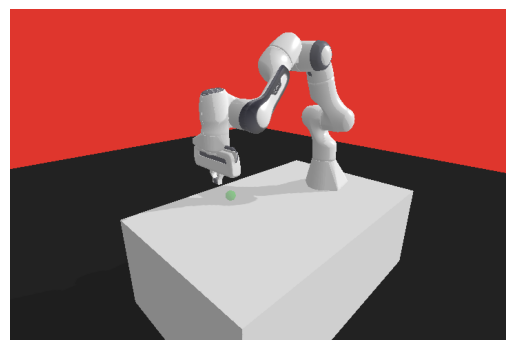

In [ ]:
print('\n観測空間:', env.observation_space)
print('\n行動空間: ', env.action_space)
print('\n初期状態: ', env.reset())
print('\n環境での1ステップ: ', env.step(np.array(1.0)))
print('\n\nレンダリングした環境: ')
env.reset()
plt.axis('off')
plt.imshow(env.render())
plt.show()

In [4]:
obs_shape = env.observation_space['observation'].shape[0] + \
            env.observation_space['achieved_goal'].shape[0] + \
            env.observation_space['desired_goal'].shape[0]

# GAIL用のエキスパート軌跡

1. `../TD3/Models/Expert/` の事前学習TD3エキスパートで軌跡（状態 + 行動）をロールアウト。
2. 生成した軌跡を一度 `./expert_trajectories.pt` に保存し、以降の実行で再利用。
3. このファイルからミニバッチを作り、学習中にGAIL識別器へ供給する。

In [ ]:
expert_path = "./expert_trajectories.pt"
if not os.path.exists(expert_path):
    collect_expert_trajectories(env_name="PandaReach-v3", episodes=200, steps_per_episode=300,
                                expert_model_path="../TD3/Models/Expert/", save_path=expert_path,
                                render=False)
else:
    print(f"キャッシュされたエキスパート軌跡を {expert_path} から利用します")

Training..:   1%|          | 6/500 [00:01<01:28,  5.58it/s]/home/shimoiyusuke/manipulator-inverse-rl/TD3/td3_algo.py:137: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state = torch.tensor([observation], dtype=torch.float32).to(self.device)
Training..:  20%|██        | 102/500 [00:18<00:58,  6.79it/s]

Episode: 100 	 Steps: 4 	 Score: -3.0 	 Average score: -41.8


Training..:  40%|████      | 202/500 [00:30<00:25, 11.60it/s]

Episode: 200 	 Steps: 3 	 Score: -2.0 	 Average score: -14.1


Training..:  60%|██████    | 302/500 [00:38<00:16, 12.08it/s]

Episode: 300 	 Steps: 4 	 Score: -3.0 	 Average score: -2.7


Training..:  80%|████████  | 402/500 [00:47<00:08, 12.13it/s]

Episode: 400 	 Steps: 2 	 Score: -1.0 	 Average score: -1.9


Training..: 100%|██████████| 500/500 [00:55<00:00,  9.04it/s]


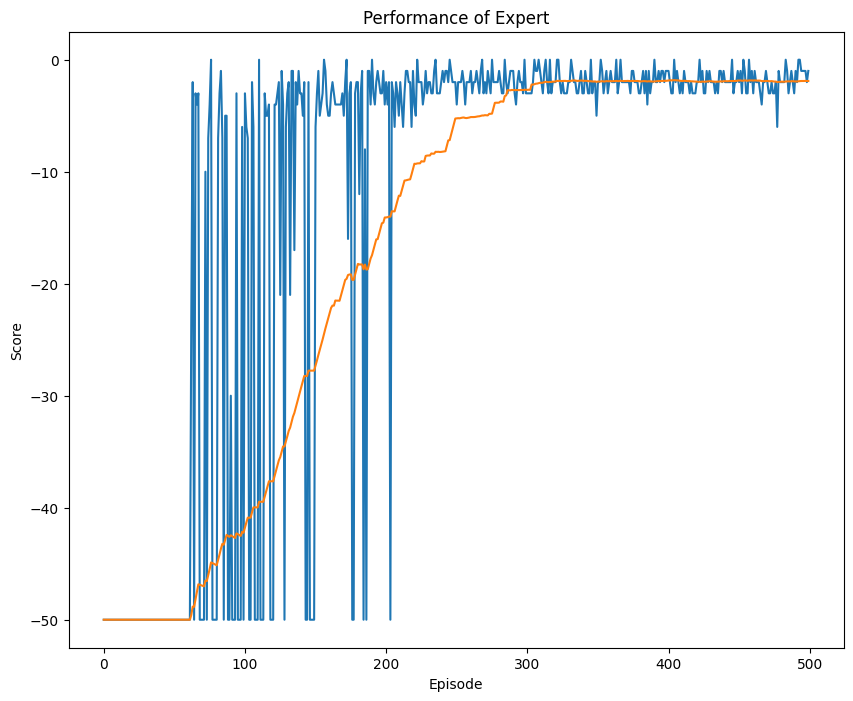

In [ ]:
expert_loader = build_expert_loader(expert_path, batch_size=256, device=None, shuffle=True)

# GAIL目的関数（数式）
- **報酬（ポリシー側）**: $r(s,a) = \log D_\phi(s,a)$。識別器が「エキスパートらしい」と判断するほど報酬が高い。
- **識別器の損失**（最小化で表記）: 
$$\mathcal{L}_D = -\mathbb{E}_{(s,a)\sim\text{expert}}[\log D_\phi(s,a)] - \mathbb{E}_{(s,a)\sim\pi_\theta}[\log (1 - D_\phi(s,a))]$$
- **ポリシー（生成側）の目的**: 
$$\max_\theta\; \mathbb{E}_{(s,a)\sim\pi_\theta}[\log D_\phi(s,a)]$$
- **TD3本体**: Actor/Critic はTD3そのまま（2つのCriticで $\min(Q_1, Q_2)$、ターゲット平滑化、遅延Actor更新）。GAILでは上記の $\log D$ を外部報酬として TD3 学習に渡す点のみが異なる。

In [ ]:
agent = GAILTrainer(env=env, input_dims=obs_shape, agent_name='GAIL',
                      model_save_path='./Models/Apprentice/',
                      exploration_period=300, disc_lr=3e-4, disc_updates=2,
                      gail_reward_scale=1.0, expert_loader=expert_loader)

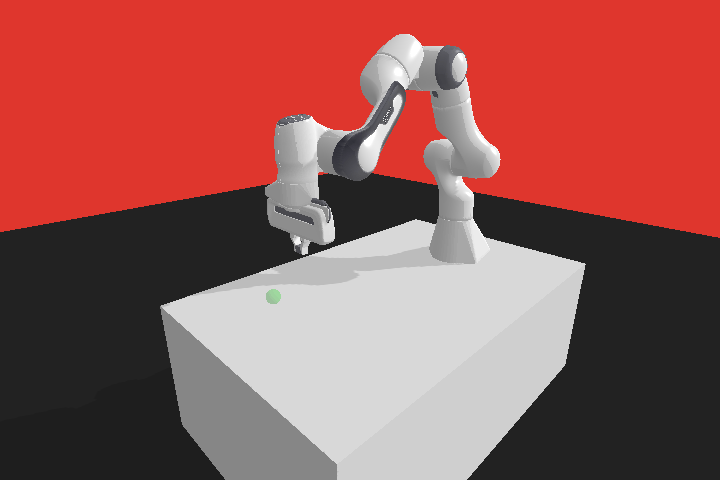

Expert Reward:  -2.0


In [ ]:
score_history, avg_score_history = agent.gail_train(n_episodes=500, opt_steps=10, print_every=50,
                                                    render_save_path=None,
                                                    plot_save_path='../Results/GAIL/GAIL Performance.png')

# GAILポリシーの評価

学習済みGAILポリシーを実行し、GIFを保存して得られた報酬を確認します。

In [ ]:
agent.save_model()
gail_reward = agent.test_model(env=env, steps=200, render_save_path='../Results/GAIL/GAIL Policy', fps=5)
print('GAILの報酬: ', gail_reward)